In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
from qulacs import ParametricQuantumCircuit, QuantumCircuit, PauliOperator
from qulacs.gate import CZ, RY,RZ, merge, ParametricRY, ParametricRZ, PauliRotation
from qulacs import QuantumState, QuantumCircuit
from qulacs import DensityMatrix, Observable
from qulacs.gate import Probabilistic, Identity, X, Y, Z, T, DepolarizingNoise, RandomUnitary, P0, P1, add, merge, DephasingNoise, to_matrix_gate, DenseMatrix
from qulacs.state import partial_trace, tensor_product
from qulacs.gate import SWAP
from qulacs.gate import H, S, Sdag, CNOT, SWAP, RZ
from qulacs import QuantumCircuit, QuantumState
from qulacs.observable import create_observable_from_openfermion_text
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev
from openfermion.linalg import get_sparse_operator
from openfermion.ops import FermionOperator
from openfermionpyscf import run_pyscf
from openfermion.linalg import get_sparse_operator
from pyscf import fci

In [ ]:
def generate_pauli_matrix(pauli_str):
    pauli_dict = {
        "I": np.array([[1, 0], [0, 1]], dtype=complex),
        "X": np.array([[0, 1], [1, 0]], dtype=complex),
        "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
        "Z": np.array([[1, 0], [0, -1]], dtype=complex)
    }
    matrix = np.array([1], dtype=complex)
    for p in pauli_str:
        matrix = np.kron(matrix, pauli_dict[p])
    return matrix

def create_global_depolarizing_noise_gate(k, epsilon):
    
    target_qubits = list(range(k))
    
    pauli_labels = ["I", "X", "Y", "Z"]
    
    identity_key = tuple("I" for _ in range(k))
    gate_prob_dict = { identity_key: 1 - epsilon + epsilon / (4**k) }
    
    
    for comb in itertools.product(pauli_labels, repeat=k):
        if comb == identity_key:
            continue
        gate_prob_dict[comb] = epsilon / (4**k)
    
    
    gate_list = []
    prob_list = []
    for pauli_tuple, prob in gate_prob_dict.items():
        
        pauli_str = list(pauli_tuple)
        matrix = generate_pauli_matrix(pauli_str)
        
        gate = DenseMatrix(target_qubits, matrix)
        gate_list.append(gate)
        prob_list.append(prob)
    

    noise_gate = Probabilistic(prob_list, gate_list)
    return noise_gate

if __name__ == '__main__':
    n_qubits = 4 
    k = 2          
    epsilon = 0.5

    noise_gate = create_global_depolarizing_noise_gate(k, epsilon)
    
    state = DensityMatrix(n_qubits)
    state.set_Haar_random_state(1111)
    circuit = QuantumCircuit(n_qubits)
    circuit.add_gate(noise_gate)
    
    print("State vector before noise:")
    print(state)
    
    circuit.update_quantum_state(state)
    
    print("State vector after noise:")
    print(state)


State vector before noise:
 *** Density Matrix ***
 * Qubit Count : 4
 * Dimension   : 16
 * Density matrix : 
           (0.00590423,0)     (0.0063648,0.0108402)  (0.000566568,-0.0113983)    (-0.0187367,0.0301818)  (0.0173017,-0.000821994)    (0.0134163,-0.0105153)  (0.000169235,0.00548244)    (0.0235958,-0.0189694)    (0.0169829,0.00672308)     (0.00143902,0.013312)   (-0.00476891,0.0337377)    (0.0128058,-0.0174336)   (0.00211634,-0.0083537)   (0.0082595,-0.00875232)   (-0.011885,-0.00987689)  (0.00919028,-0.00988288)
   (0.0063648,-0.0108402)             (0.0267639,0)   (-0.0203165,-0.0133276)     (0.0352157,0.0669368)    (0.0171422,-0.0326521)  (-0.00484325,-0.0359679)     (0.0102482,0.0055994)  (-0.00939149,-0.0637712)    (0.0306513,-0.0239332)     (0.0259922,0.0117084)     (0.0568016,0.0451252)   (-0.0182035,-0.0423051)     (-0.013056,-0.012891)  (-0.00716549,-0.0245995)    (-0.0309461,0.0111736)  (-0.00823782,-0.0275272)
  (0.000566568,0.0113983)    (-0.0203165,0.0133276)      

In [20]:
def exact_time_evolution(rho_input, n_qubit, theta):
    rho = rho_input.copy()
    
    #define constants
    basis = "sto-3g"  #basis set
    multiplicity = 1  #spin multiplicity
    charge = 0        #total charge for the molecule
    distance = 1.1
    geometry = [("H",(0,0,0)),("H", (0,0,distance))]  #xyz coordinates for atoms
    description = str(distance)  #description for the psi4 output file

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
    hamiltonian_matrix = get_sparse_operator(jw_hamiltonian).toarray()
    U_mat = scipy.linalg.expm(1j * theta / 2 * hamiltonian_matrix)
    exp_H = DenseMatrix([i for i in range(n_qubit)], U_mat)
    exp_H.update_quantum_state(rho)
    
    return rho

def noisy_time_evolution(rho_input, n_qubit, layer, theta, p_err):
    rho = rho_input.copy()
    for l in range(layer):
        rho = exact_time_evolution(rho, n_qubit, theta)
        #for n in range(n_qubit):
        #    DepolarizingNoise(n, p_err).update_quantum_state(rho)
    
    noise_gate = create_global_depolarizing_noise_gate(n_qubit, p_err*layer*n_qubit)
    noise_gate.update_quantum_state(rho)

    return rho

def symmetric_channel_verification_U1(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, noise = True):
    layer_per_purification = layer // verification_frequensy
    p_err_gadget = 0
    if noise:
        p_err_gadget = p_err
    rho = rho_input.copy()
    n_U1 = int(np.ceil(np.log2(n_qubit+1)))

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_U1)
        rho = tensor_product(rho_ancilla, rho)

        for n in range(n_U1):
            H(n_qubit+n).update_quantum_state(rho)

        for n1 in range(n_U1):
            for n2 in range(n_qubit):
                Phase_gate = DenseMatrix(n2, [[1 , 0], [0, np.exp(1j*2*np.pi/2**n_U1 * 2**n1)]])
                Phase_gate.add_control_qubit(n_qubit+n1, 1)
                Phase_gate.update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        for n in range(n_U1):
            DepolarizingNoise(n_qubit+n1, p_err_gadget).update_quantum_state(rho)

        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        for n1 in range(n_U1):
            for n2 in range(n_qubit):
                Phase_gate = DenseMatrix(n2, [[1 , 0], [0, np.exp(-1j*2*np.pi/2**n_U1 * 2**n1)]])
                Phase_gate.add_control_qubit(n_qubit+n1, 1)
                Phase_gate.update_quantum_state(rho)

        for n1 in range(n_U1):
            for n2 in range(0, n1):
                Phase_gate = DenseMatrix(n_qubit+n1, [[1 , 0], [0, np.exp(-1j*2*np.pi/2**(n2-n1+1))]])
                Phase_gate.add_control_qubit(n_qubit+n2, 1)
                Phase_gate.update_quantum_state(rho)
            H(n_qubit+n1).update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        for n in range(n_U1):
            DepolarizingNoise(n_qubit+n1, p_err_gadget).update_quantum_state(rho)

        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_U1), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit + i for i in range(n_U1)])

    return rho


def symmetric_channel_verification_parity(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, with_ancilla_noise = True):
    p_err_gadget = p_err / 100
    layer_per_purification = layer // verification_frequensy
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(1)
        rho = tensor_product(rho_ancilla, rho)

        for n in range(n_qubit):
            CNOT(n, n_qubit).update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        if with_ancilla_noise:
            DepolarizingNoise(n_qubit, p_err_gadget).update_quantum_state(rho)

        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        for n in range(n_qubit):
            CNOT(n, n_qubit).update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        if with_ancilla_noise:
            DepolarizingNoise(n_qubit, p_err_gadget).update_quantum_state(rho)

        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(1), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit])

    return rho
    

In [27]:
n_qubit = 4
layer_list = np.array([1, 2, 5, 10, 20, 50, 100], dtype = 'int')
p_err = 10**(-4)
theta = 2 * np.pi / 100
seed = 12345

tracedist_noisy_list = np.zeros(len(layer_list))
tracedist_SCV_list = np.zeros(len(layer_list))
tracedist_SCV_noiseless_list = np.zeros(len(layer_list))
tracedist_SCV_parity_list = np.zeros(len(layer_list))

for layer_index, layer in enumerate(layer_list):
    rho_initial = DensityMatrix(n_qubit)
    rho_initial.set_Haar_random_state(seed)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_SCV = symmetric_channel_verification_U1(rho_initial, n_qubit, layer, theta, p_err, noise = True)
    rho_SCV_noiseless = symmetric_channel_verification_U1(rho_initial, n_qubit, layer, theta, p_err, noise = False)
    rho_SCV_parity = symmetric_channel_verification_parity(rho_initial, n_qubit, layer, theta, p_err)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_SCV = rho_SCV.get_matrix()
    rho_SCV_noiseless = rho_SCV_noiseless.get_matrix()
    rho_SCV_parity = rho_SCV_parity.get_matrix()

    tracedist_noisy_list[layer_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_SCV_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV / np.trace(rho_SCV), ord = 'nuc') / 2
    tracedist_SCV_noiseless_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_noiseless / np.trace(rho_SCV_noiseless), ord = 'nuc') / 2
    tracedist_SCV_parity_list[layer_index] = np.linalg.norm(rho_ideal - rho_SCV_parity / np.trace(rho_SCV_parity), ord = 'nuc') / 2

    print(layer)

1
2
5
10
20
50
100


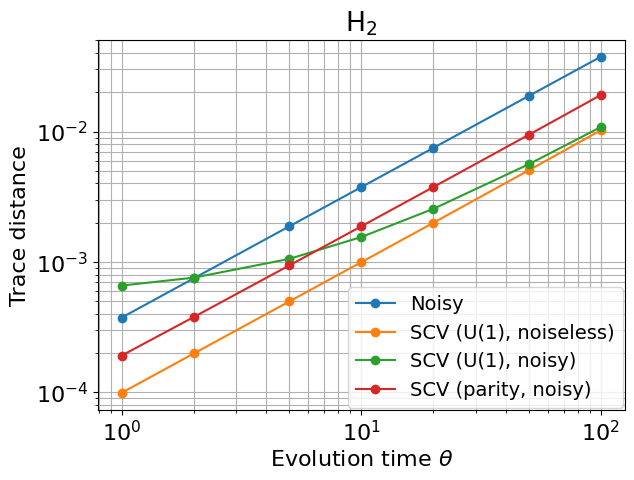

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(layer_list, tracedist_noisy_list, marker = 'o', label = 'Noisy')
plt.plot(layer_list, tracedist_SCV_noiseless_list, marker = 'o', label = 'SCV (U(1), noiseless)')
plt.plot(layer_list, tracedist_SCV_list, marker = 'o', label = 'SCV (U(1), noisy)')
plt.plot(layer_list, tracedist_SCV_parity_list, marker = 'o', label = 'SCV (parity, noisy)')

plt.xscale('log')
plt.yscale('log')
plt.title('H$_2$')
plt.xlabel(r'Evolution time $\theta$')
plt.ylabel('Trace distance')
#plt.xlim(0,22)
#plt.ylim(10**(-3.5),10**(-0.1))
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1, fontsize=14)
plt.grid(which='both', axis='both')
#plt.savefig('H2_U1.pdf', bbox_inches='tight')